In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import math
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion,make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import sklearn.metrics
import warnings

# Feature estimation functions

In [3]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye

def average(y_pred, window_size=2000):
    for i in range(len(y_pred)):
        if i < window_size or i >= len(y_pred) - window_size:
            pass
        else:
            average = float(sum(y_pred[i-window_size:i+window_size+1])) / (2*window_size+1)
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred


# Load dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DDD/Normalized_Datset.csv')

In [5]:
df.head()

,EAR,MAR,CIR,MOE,EAR_N,MAR_N,CIR_N,MOE_N,State
0,0.376371,1.253342,0.650692,3.330069,-1.137820,0.137071,-0.571872,0.770337,0
1,0.405949,1.208933,0.758213,2.978043,1.296250,-1.287514,1.406080,-1.412269,0
2,0.388272,1.284932,0.636432,3.309359,-0.158430,1.150443,-0.834208,0.641932,0
3,0.354285,1.274304,0.613747,3.596831,-2.955369,0.809510,-1.251522,2.424296,0
4,0.356203,1.277650,0.604534,3.586857,-2.797551,0.916817,-1.421012,2.362458,0


# Exploratory Data Analysis

## Descriptive Statistics

In [6]:
df.describe()

,EAR,MAR,CIR,MOE,EAR_N,MAR_N,CIR_N,MOE_N,State
count,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000
mean,0.292279,1.040864,0.602411,3.727154,-2.264692,3.124449,-4.627137,4.005877,0.496977
std,0.062456,0.188514,0.076974,1.076739,6.233996,16.537507,32.359309,17.146027,0.500004
min,0.077977,0.200033,0.305892,0.689280,-65.934185,-183.183547,-496.231940,-41.047401,0.000000
25%,0.250514,0.928047,0.550632,3.024561,-3.833681,-2.093121,-3.228850,-1.127188,0.000000
50%,0.297386,1.013727,0.605053,3.518939,-0.992183,0.334120,-0.831012,0.855727,0.000000
75%,0.338127,1.138272,0.656532,4.139437,0.792791,4.391722,0.854743,4.941849,1.000000
max,0.570214,3.997724,1.049081,13.438747,80.539640,268.091494,1136.150622,550.749585,1.000000


## Distribution of various features

### EAR

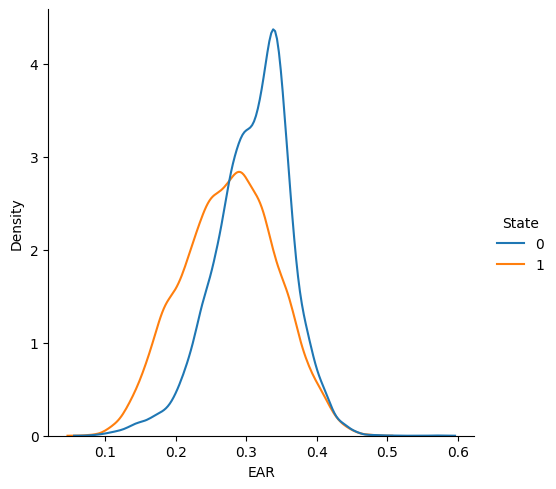

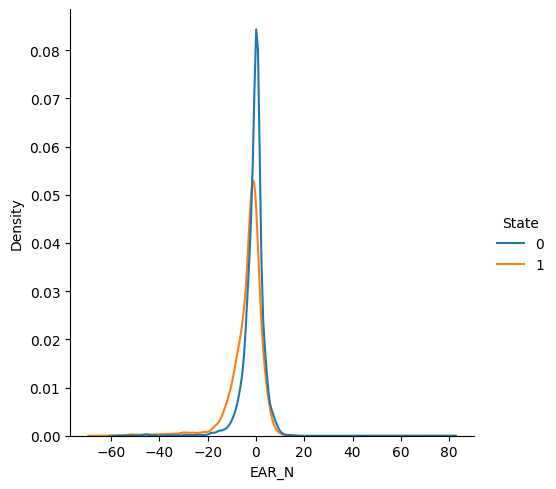

In [7]:
sns.displot(data = df, x = df['EAR'], kind ='kde', hue = 'State')
sns.displot(data = df, x = df['EAR_N'], kind ='kde', hue = 'State')

### MAR

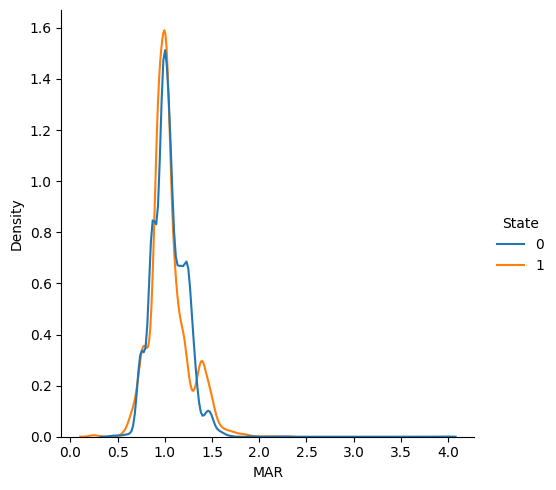

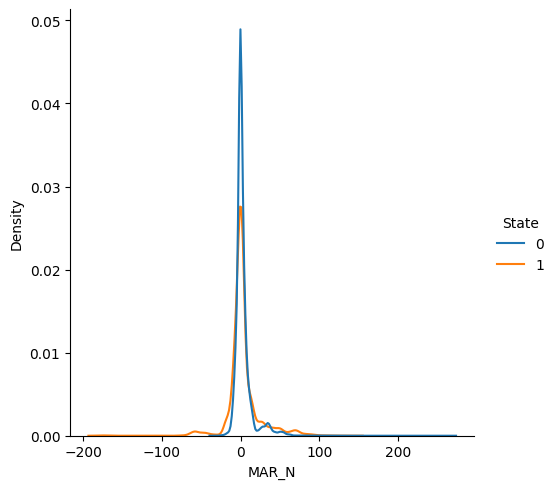

In [8]:
sns.displot(data = df, x = df['MAR'], kind ='kde', hue = 'State')
sns.displot(data = df, x = df['MAR_N'], kind ='kde', hue = 'State')

### MOE

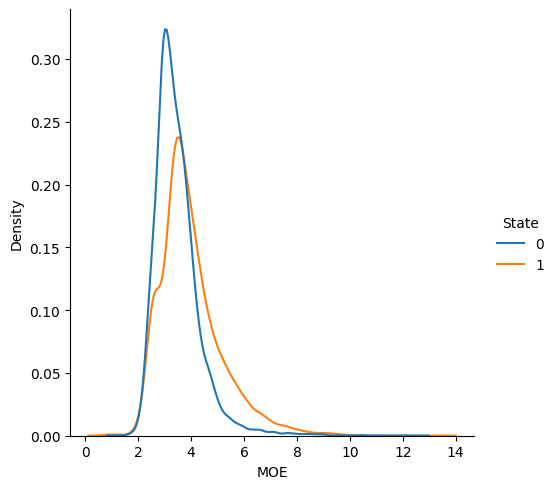

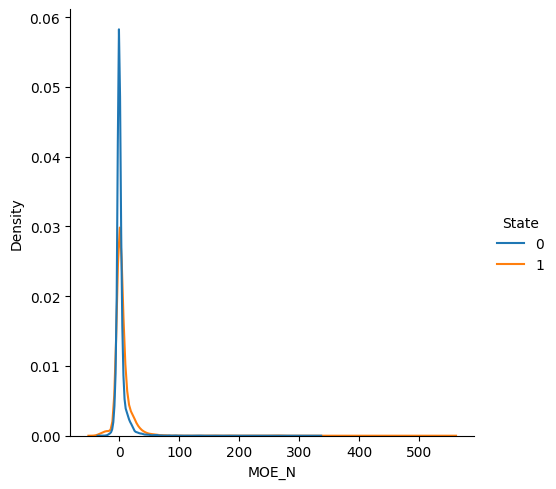

In [9]:
sns.displot(data = df, x = df['MOE'], kind ='kde', hue = 'State')
sns.displot(data = df, x = df['MOE_N'], kind ='kde', hue = 'State')

### CIR

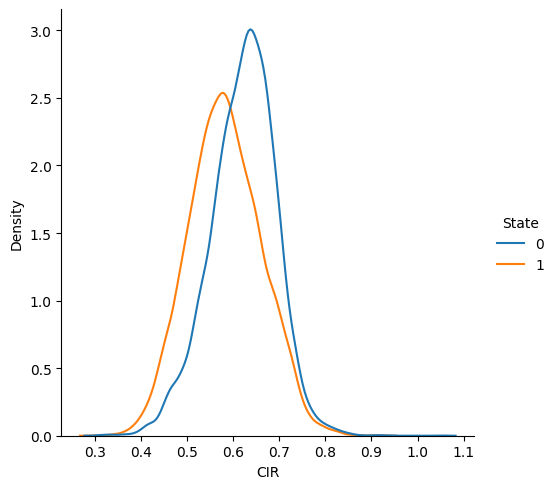

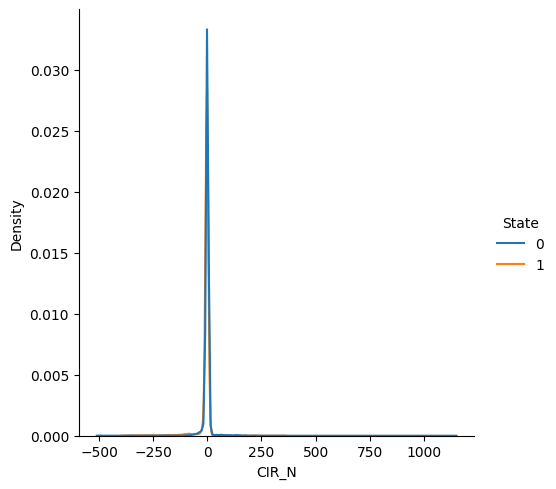

In [10]:
sns.displot(data = df, x = df['CIR'], kind ='kde', hue = 'State')
sns.displot(data = df, x = df['CIR_N'], kind ='kde', hue = 'State')

# Model Building

In [11]:
X = df.drop(['State'], axis = 1).copy()
y = df['State'].copy()

In [12]:
print(X.shape,y.shape)

(19681, 8) (19681,)


### Train-Test-Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8,random_state = 0)

In [44]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(14760, 8) (4921, 8) (14760,) (4921,)


### Logistic Regression

accuracy: 0.6507, F1 score: 0.6261, ROC AUC: 0.6842
[[1411  637]
 [ 738 1151]]


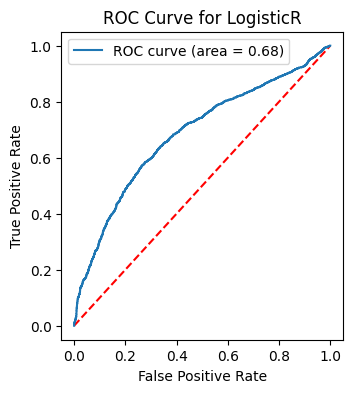

In [47]:
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = average(y_pred)
y_prob_lg = model.predict_proba(X_test)[:, 1]

acc_lg = accuracy_score(y_test, y_pred)
f1_lg = f1_score(y_test, y_pred)
roc_auc_lg = roc_auc_score(y_test, y_prob_lg)

print(f"accuracy: {acc_lg:.4f}, F1 score: {f1_lg:.4f}, ROC AUC: {roc_auc_lg:.4f}")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'r--')
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lg)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_lg:.2f})")
plt.title('ROC Curve for LogisticR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('lr_ROC.png', format='png')


In [20]:
!pip install -U joblib

In [16]:
import joblib

In [28]:
joblib.dump(model, 'lr_model.joblib')

['lr_model.joblib']

### Naive Bayes

Accuracy: 0.6355, F1 score: 0.5047, ROC AUC: 0.7067
[[1771  277]
 [1158  731]]


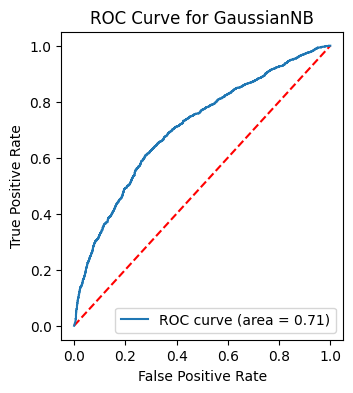

In [48]:
model = make_pipeline(StandardScaler(), GaussianNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = average(y_pred)
y_prob_nb = model.predict_proba(X_test)[:, 1]

acc_nb = accuracy_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred)
roc_auc_nb = roc_auc_score(y_test, y_prob_nb)

print(f"Accuracy: {acc_nb:.4f}, F1 score: {f1_nb:.4f}, ROC AUC: {roc_auc_nb:.4f}")
print(confusion_matrix(y_test, y_pred))

# Plot the ROC curve
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'r--')
fpr, tpr, thresholds = roc_curve(y_test, y_prob_nb)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_nb:.2f})")
plt.title('ROC Curve for GaussianNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('GaussianNB.png', format='png')


In [26]:
joblib.dump(model, 'GaussianNB_model.joblib')

['GaussianNB_model.joblib']

### K-Nearest Neighbours

In [49]:
from sklearn import metrics
acc_list_knn = []
f1_score3_list = []
roc_3_list = []

for i in range(1,50):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_knn = neigh.predict_proba(X_test)[:,1]
    acc_list_knn.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_knn))

neigh = KNeighborsClassifier(n_neighbors=acc_list_knn.index(max(acc_list_knn))+1)
neigh.fit(X_train, y_train)
pred_KN = neigh.predict(X_test)
pred_KN = average(pred_KN)
y_score_knn = neigh.predict_proba(X_test)[:,1]
acc_knn = accuracy_score(y_test, pred_KN)
f1_score_knn = metrics.f1_score(y_test, pred_KN)
roc_knn = metrics.roc_auc_score(y_test, y_score_knn)
print([acc_knn,f1_score_knn,roc_knn])
print(confusion_matrix(y_test, pred_KN))

[0.8110236220472441, 0.8070539419087137, 0.8779923705085364]
[[1637  411]
 [ 333 1556]]


Accuracy, F1-score, and ROC AUC score:
[0.8110236220472441, 0.8070539419087137, 0.8779923705085364]
Confusion matrix:
[[1637  411]
 [ 333 1556]]


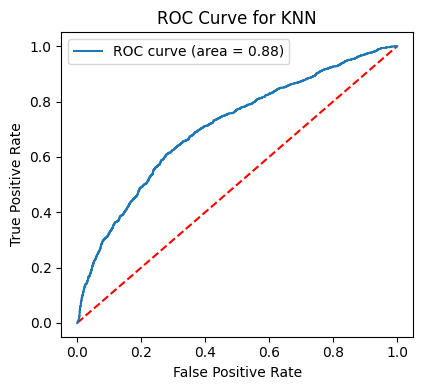

In [50]:
# Define the number of neighbors to use in the KNN model
n_neighbors = np.argmax(acc_list_knn) + 1

# Train the KNN model
neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(X_train, y_train)

# Make predictions on the test set and evaluate the model's performance
pred_KN = neigh.predict(X_test)
pred_KN = average(pred_KN)
y_score_knn = neigh.predict_proba(X_test)[:,1]

acc_knn = accuracy_score(y_test, pred_KN)
f1_score_knn = f1_score(y_test, pred_KN)
roc_knn = roc_auc_score(y_test, y_score_knn)

print("Accuracy, F1-score, and ROC AUC score:")
print([acc_knn, f1_score_knn, roc_knn])

print("Confusion matrix:")
print(confusion_matrix(y_test, pred_KN))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'r--')
fpr, tpr, thresholds = roc_curve(y_test, y_prob_nb)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_knn:.2f})")
plt.title('ROC Curve for KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('KNN.png', format='png')

plt.tight_layout()
plt.show()


In [33]:
joblib.dump(neigh, 'KNN.joblib')

['KNN.joblib']

### Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

max_depth_range = range(2, 11)

# Train Decision Tree models with different max_depth values and record the accuracy scores
accuracy_scores = []
for depth in max_depth_range:
    clf_DT = DecisionTreeClassifier(random_state=0, max_depth=depth)
    clf_DT.fit(X_train, y_train)
    pred_DT = clf_DT.predict(X_test)
    pred_DT = average(pred_DT)
    accuracy = accuracy_score(pred_DT, y_test)
    accuracy_scores.append(accuracy)

# Find the value of max_depth that gave the highest accuracy score
best_accuracy = max(accuracy_scores)
best_max_depth = max_depth_range[accuracy_scores.index(best_accuracy)]

print(f"Best accuracy: {best_accuracy:.4f} (max_depth={best_max_depth})")


Best accuracy: 0.7861 (max_depth=10)


Accuracy: 0.7861
F1 score: 0.7778
ROC AUC score: 0.8458
[[1621  427]
 [ 415 1474]]


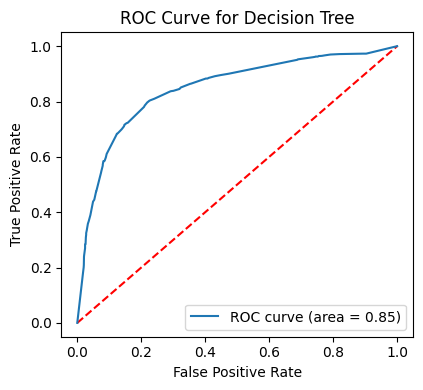

In [52]:
# Train a Decision Tree classifier with the best max_depth value
clf_DT = DecisionTreeClassifier(random_state=0, max_depth=best_max_depth)
clf_DT.fit(X_train, y_train)

# Predict on the test set and compute evaluation metrics
pred_DT = clf_DT.predict(X_test)
pred_DT = average(pred_DT)
y_score_dt = clf_DT.predict_proba(X_test)[:, 1]
acc_dt = accuracy_score(y_test, pred_DT)
f1_score_5 = metrics.f1_score(y_test, pred_DT)
roc_5 = metrics.roc_auc_score(y_test, y_score_dt)

# Print the evaluation metrics
print(f"Accuracy: {acc_dt:.4f}")
print(f"F1 score: {f1_score_5:.4f}")
print(f"ROC AUC score: {roc_5:.4f}")
print(confusion_matrix(y_test, pred_DT))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'r--')
fpr, tpr, thresholds = roc_curve(y_test, y_score_dt)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_5:.2f})")
plt.title('ROC Curve for Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('Dt.png', format='png')

plt.tight_layout()
plt.show()


In [30]:
joblib.dump(clf_DT, 'dt.joblib')

['dt.joblib']

### Random Forest

In [53]:
acc6 = []
max_depth = []

for i in range(1, 10):
    clf_RF = RandomForestClassifier(max_depth=i)
    clf_RF.fit(X_train, y_train)
    pred_RF = clf_RF.predict(X_test)
    pred_RF = average(pred_RF)
    acc = metrics.accuracy_score(y_test, pred_RF)
    acc6.append(acc)
    max_depth.append(i)

max_acc = max(acc6)
best_depth = max_depth[acc6.index(max_acc)]
print(f"Maximum accuracy score: {max_acc}")
print(f"Best max_depth: {best_depth}")

Maximum accuracy score: 0.8219456438912878
Best max_depth: 9


accuracy: 0.8204216408432817, F1 Score: 0.8078282141886383, ROC AUC Score: 0.8992592290067496
[[1744  304]
 [ 403 1486]]


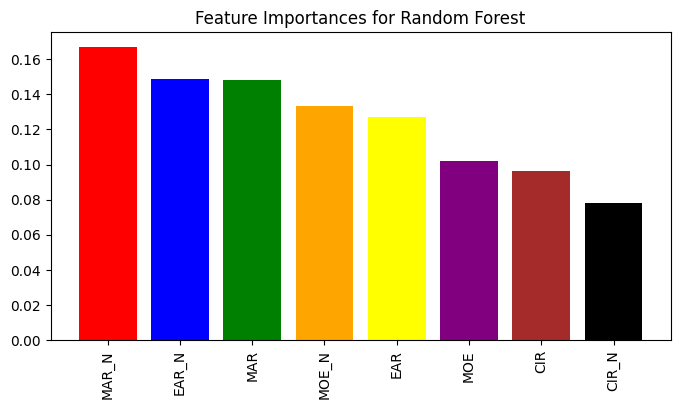

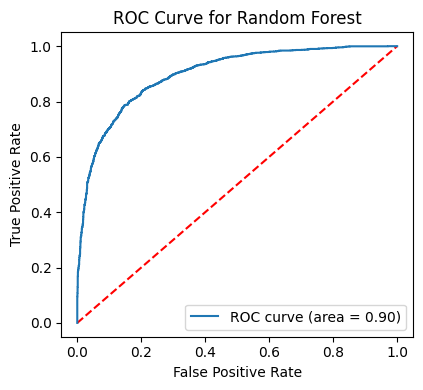

In [57]:
# Train a random forest classifier with the best depth
rf_classifier = RandomForestClassifier(max_depth=9)
rf_classifier.fit(X_train, y_train)

# Make predictions and calculate performance metrics
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)
y_score_rf = rf_classifier.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_score_rf)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(f"accuracy: {accuracy_rf}, F1 Score: {f1_score_rf}, ROC AUC Score: {roc_auc_rf}")
print(confusion_matrix_rf)

feature_importances_rf = pd.DataFrame(rf_classifier.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(8, 4))
plt.bar(feature_importances_rf.index, feature_importances_rf['importance'], color = ['red','blue','green','orange','yellow','purple','brown','black'])
plt.xticks(rotation=90)
plt.title('Feature Importances for Random Forest')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'r--')
fpr, tpr, thresholds = roc_curve(y_test, y_score_rf)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.title('ROC Curve for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('rf.png', format='png')
plt.tight_layout()
plt.show()


In [32]:
joblib.dump(rf_classifier, 'RandomForest_82.joblib')

['RandomForest_82.joblib']

# Model Evaluation

## Model Accuracy

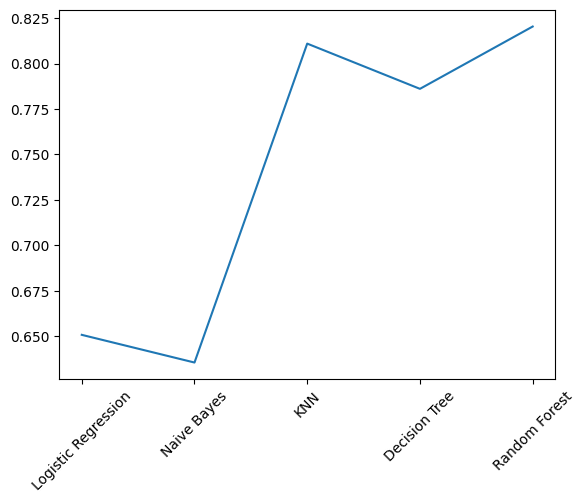

In [59]:
acc_total = {'Model':['Logistic Regression','Naive Bayes', 'KNN','Decision Tree','Random Forest'],
        'Accuracy':[acc_lg,acc_nb, acc_knn, acc_dt, accuracy_rf]}
acc_total=pd.DataFrame(acc_total)
acc_total=acc_total.set_index('Model')
acc_total
plt.plot(acc_total['Accuracy'])
plt.xticks(rotation=45)
plt.savefig('accuracy.png', format='png')

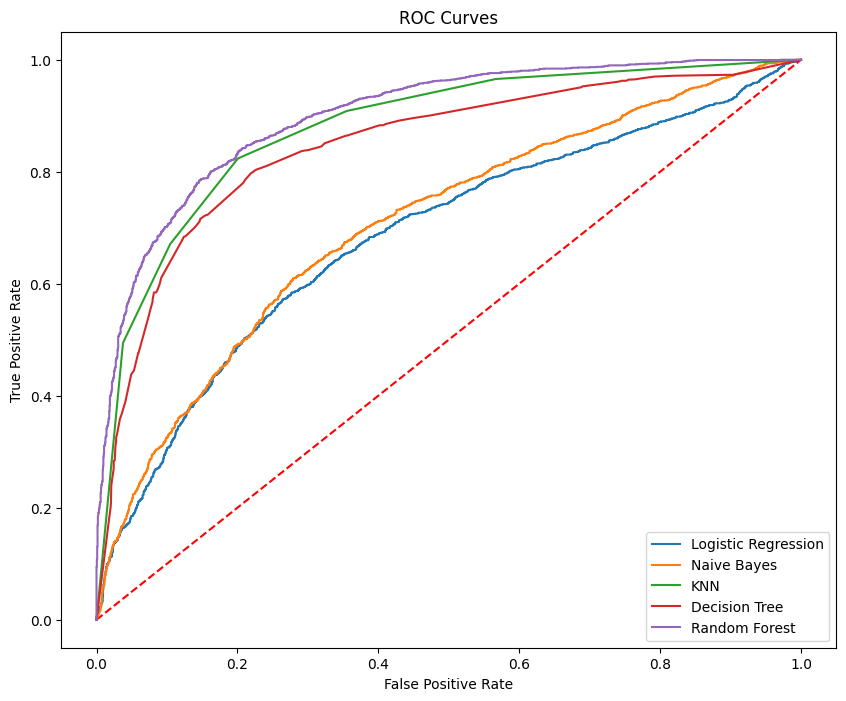

In [61]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1],'r--')
fpr_1, tpr_1, thresholds = roc_curve(y_test, y_prob_lg)
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_prob_nb)
fpr_3, tpr_3, thresholds = roc_curve(y_test, y_score_knn)
fpr_5, tpr_5, thresholds = roc_curve(y_test, y_score_dt)
fpr_6, tpr_6, thresholds = roc_curve(y_test, y_score_rf)
plt.plot(fpr_1, tpr_1, label= "Logistic Regression")
plt.plot(fpr_2, tpr_2, label= "Naive Bayes")
plt.plot(fpr_3, tpr_3, label= "KNN")
plt.plot(fpr_5, tpr_5, label= "Decision Tree")
plt.plot(fpr_6, tpr_6, label= "Random Forest")
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('roc_curves.png', format='png')